# Hyperparameter Optimisation II

In [1]:
import numpy as np
import pickle
import argparse
import ConfigSpace as CS
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.ERROR)
from copy import deepcopy

from smac.facade.smac_facade import SMAC
from smac.scenario.scenario import Scenario

import hpbandster.distributed.utils
from hpbandster.distributed.worker import Worker


def create_config_space():
    cs = CS.ConfigurationSpace()

    Adam_final_lr_fraction = CS.UniformFloatHyperparameter('Adam_final_lr_fraction',
                                           lower=1e-4, upper=1e-0, default_value=1e-2, log=True)
    cs.add_hyperparameter(Adam_final_lr_fraction)    

    Adam_initial_lr = CS.UniformFloatHyperparameter('Adam_initial_lr',
                                           lower=1e-4, upper=1e-2, default_value=1e-3, log=True)
    cs.add_hyperparameter(Adam_initial_lr)    

    SGD_final_lr_fraction = CS.UniformFloatHyperparameter('SGD_final_lr_fraction',
                                           lower=1e-4, upper=1e-0, default_value=1e-2, log=True)
    cs.add_hyperparameter(SGD_final_lr_fraction)     

    SGD_initial_lr = CS.UniformFloatHyperparameter('SGD_initial_lr',
                                           lower=1e-3, upper=0.5, default_value=1e-1, log=True)
    cs.add_hyperparameter(SGD_initial_lr)  

    SGD_momentum = CS.UniformFloatHyperparameter('SGD_momentum',
                                           lower=0.0, upper=0.99, default_value=0.9, log=False)
    cs.add_hyperparameter(SGD_momentum)      
    
    StepDecay_epochs_per_step = CS.UniformIntegerHyperparameter('StepDecay_epochs_per_step',
                                                   lower=1, default_value=16,upper=128,log=True)
    cs.add_hyperparameter(StepDecay_epochs_per_step)    

    activation = CS.CategoricalHyperparameter('activation', ['relu', 'tanh'])
    cs.add_hyperparameter(activation)    

    batch_size = CS.UniformIntegerHyperparameter('batch_size', lower=8, default_value=16,upper=256,log=False)
    cs.add_hyperparameter(batch_size)      
    
    dropout_0 = CS.UniformFloatHyperparameter('dropout_0',lower=0.0, upper=0.5, default_value=0, log=False) 
    dropout_1 = CS.UniformFloatHyperparameter('dropout_1',lower=0.0, upper=0.5, default_value=0, log=False) 
    dropout_2 = CS.UniformFloatHyperparameter('dropout_2',lower=0.0, upper=0.5, default_value=0, log=False)     
    dropout_3 = CS.UniformFloatHyperparameter('dropout_3',lower=0.0, upper=0.5, default_value=0, log=False)   
    cs.add_hyperparameters([dropout_0, dropout_1, dropout_2, dropout_3]) 

    l2_reg_0 = CS.UniformFloatHyperparameter('l2_reg_0', lower=1e-6, upper=1e-2, default_value=1e-4, log=True)
    l2_reg_1 = CS.UniformFloatHyperparameter('l2_reg_1', lower=1e-6, upper=1e-2, default_value=1e-4, log=True)                                               
    l2_reg_2 = CS.UniformFloatHyperparameter('l2_reg_2', lower=1e-6, upper=1e-2, default_value=1e-4, log=True)    
    l2_reg_3 = CS.UniformFloatHyperparameter('l2_reg_3', lower=1e-6, upper=1e-2, default_value=1e-4, log=True)
    cs.add_hyperparameters([l2_reg_0, l2_reg_1, l2_reg_2, l2_reg_3])

    learning_rate_schedule = CS.CategoricalHyperparameter('learning_rate_schedule', ['ExponentialDecay', 'StepDecay'])
    loss_function = CS.CategoricalHyperparameter('loss_function', ['categorical crossentropy'])
    num_layers = CS.UniformIntegerHyperparameter('num_layers',lower=1, default_value=2, upper=4, log=False)    
    cs.add_hyperparameters([learning_rate_schedule, loss_function, num_layers])

    num_units_0 = CS.UniformIntegerHyperparameter('num_units_0',lower=16, default_value=32, upper=256, log=True)    
    num_units_1 = CS.UniformIntegerHyperparameter('num_units_1',lower=16, default_value=32, upper=256, log=True) 
    num_units_2 = CS.UniformIntegerHyperparameter('num_units_2',lower=16, default_value=32, upper=256, log=True)     
    num_units_3 = CS.UniformIntegerHyperparameter('num_units_3',lower=16, default_value=32, upper=256, log=True)     
    cs.add_hyperparameters([num_units_0, num_units_1, num_units_2, num_units_3]) 

    optimizer = CS.CategoricalHyperparameter('optimizer', ['Adam', 'SGD'])    
    output_activation = CS.CategoricalHyperparameter('output_activation', ['softmax'])    
    cs.add_hyperparameters([optimizer, output_activation]) 
    
    # implement conditions
    use_Adam_final_lr_fraction = CS.EqualsCondition(Adam_final_lr_fraction, optimizer, 'Adam')
    use_Adam_initial_lr = CS.EqualsCondition(Adam_initial_lr, optimizer, 'Adam')
    use_SGD_final_lr_fraction = CS.EqualsCondition(SGD_final_lr_fraction, optimizer, 'SGD')
    use_SGD_initial_lr = CS.EqualsCondition(SGD_initial_lr, optimizer, 'SGD')    
    use_SGD_momentum = CS.EqualsCondition(SGD_momentum, optimizer, 'SGD')    
    
    #use_Adam_initial_lr = CS.InCondition(child=Adam_initial_lr, parent=optimizer, values=["Adam"])
    #use_SGD_final_lr_fraction = CS.InCondition(child=SGD_final_lr_fraction, parent=optimizer, values=["SGD"])
    #use_SGD_initial_lr = CS.InCondition(child=SGD_initial_lr, parent=optimizer, values=["SGD"])    
    #use_SGD_momentum = CS.InCondition(child=SGD_momentum, parent=optimizer, values=["SGD"])
    
    use_dropout_1 = CS.GreaterThanCondition(dropout_1, num_layers, 1)
    use_dropout_2 = CS.GreaterThanCondition(dropout_2, num_layers, 2)
    use_dropout_3 = CS.GreaterThanCondition(dropout_3, num_layers, 3)
  
    use_l2_reg_1 = CS.GreaterThanCondition(l2_reg_1, num_layers, 1)
    use_l2_reg_2 = CS.GreaterThanCondition(l2_reg_2, num_layers, 2)
    use_l2_reg_3 = CS.GreaterThanCondition(l2_reg_3, num_layers, 3)

    use_num_units_1 = CS.GreaterThanCondition(num_units_1, num_layers, 1)
    use_num_units_2 = CS.GreaterThanCondition(num_units_2, num_layers, 2)
    use_num_units_3 = CS.GreaterThanCondition(num_units_3, num_layers, 3)   
    
    cs.add_conditions([use_Adam_final_lr_fraction, use_Adam_initial_lr, 
                       use_SGD_final_lr_fraction, use_SGD_initial_lr, use_SGD_momentum,
                       use_dropout_1, use_dropout_2, use_dropout_3,
                       use_l2_reg_1, use_l2_reg_2, use_l2_reg_3,
                       use_num_units_1, use_num_units_2, use_num_units_3]) 
    print("config space created")
    return cs


def objective_function(config, epoch=127, **kwargs):
    """
        Function wrapper to approximate the validation error of the hyperparameter configurations x by the 
        prediction of a surrogate regression model, which was trained on the validation error of randomly sampled 
        hyperparameter configurations. The original surrogate predicts the validation error after a given epoch. 
        Since all hyperparameter configurations were trained for a total amount of 
        127 epochs, we will query the performance after epoch 40. (???)
    """    
    # Cast the config to an array such that it can be forwarded to the surrogate
    x = deepcopy(config.get_array())   # 
    # print("x",x)
    x[np.isnan(x)] = -1    # set all nan values to -1 (e.g. values not-defined because of conditions)
    # print("x after isnan",x)
    # simulation: here normally a training run would be started, yielding a learning curve and time stamps
    # surrogate values for both provided by random forest
    lc = rf.predict(x[None, :])[0]    # 
    c = cost_rf.predict(x[None, :])[0]   # time stamps 

    return lc[epoch], {"cost": c, "learning_curve": lc[:epoch].tolist()}


class WorkerWrapper(Worker):
    def compute(self, config, budget, *args, **kwargs):
        cfg = CS.Configuration(cs, values=config)
        loss, info = objective_function(cfg, epoch=int(budget))

        return ({
            'loss': loss,
            'info': {"runtime": info["cost"],
                     "lc": info["learning_curve"]}
        })

In [2]:
# run smac
n_iters = 50  # take default 50

cs = create_config_space()
# as in exercise 5 surrogate function simulating mnist network returning cost
rf = pickle.load(open("./rf_surrogate_paramnet_mnist.pkl", "rb"))   # random forest surrogate function
# as in exercise 5 surrogate function runtime 
cost_rf = pickle.load(open("./rf_cost_surrogate_paramnet_mnist.pkl", "rb"))

# initialise a scenario object for SMAC providing ingredients 
scenario = Scenario({"run_obj": "quality",        # we optimize quality (alternatively runtime)
                     "runcount-limit": n_iters,   # maximum function evaluations
                     "cs": cs,                    # pass configuration space
                     "deterministic": "true",
                     "output_dir": ""})
print("scenario built")
# create SMAC instance, pass "Target Algorithm Evaluator" 
smac = SMAC(scenario=scenario, tae_runner=objective_function)
smac.optimize()
print("optimisation done")

config space created


/home/jochen/tensorflow/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jochen/tensorflow/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


scenario built
optimisation done


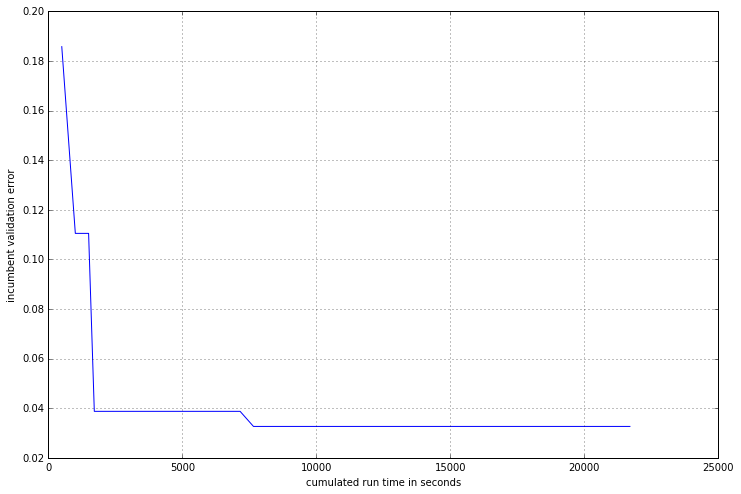

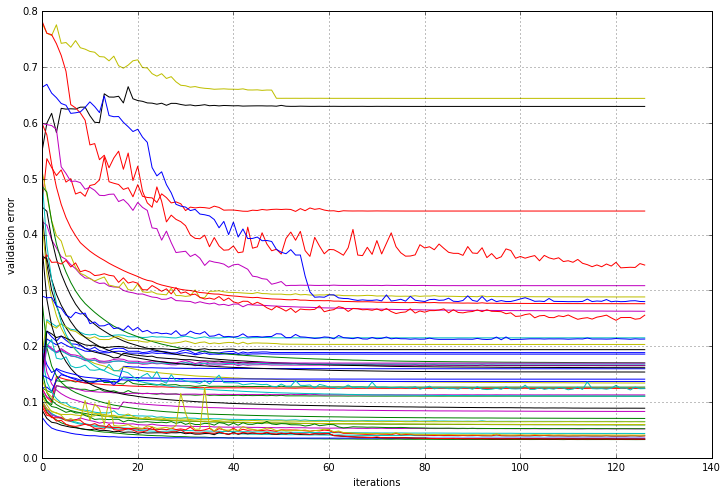

In [22]:
# evaluate results of smac run

# The following lines extract the incumbent strategy and the estimated wall-clock time of the optimization
rh = smac.runhistory
incumbents = []
incumbent_performance = []
inc = None
inc_value = 1
idx = 1
t = smac.get_trajectory()   # List of all runs with new incumbents 

wall_clock_time = []
cum_time = 0
for d in rh.data:   # get wall clock time points of all runs in run history
    cum_time += rh.data[d].additional_info["cost"]
    wall_clock_time.append(cum_time)
# print("wall_clock_time", wall_clock_time)

for i in range(n_iters):    # iterate over all runs 
    if idx < len(t) and i == t[idx].ta_runs - 1:   # if this run is new incumbent / best performer
        inc = t[idx].incumbent
        inc_value = t[idx].train_perf
        idx += 1

    incumbents.append(inc)                    # append current incumbent (if new or not)
    incumbent_performance.append(inc_value)

# print("incumbents",incumbents)
# print("incumbents-perform",incumbent_performance)            

# TODO: save and plot the wall clock time and the validation error of the incumbent after each iteration here

plt.figure(figsize=(12, 8))
# for i, incs in enumerate(rand_incumbents):
plt.plot(wall_clock_time,incumbent_performance)
plt.grid(True)
plt.xlabel("cumulated run time in seconds")
plt.ylabel("incumbent validation error")
# plt.legend(loc='best')        

lc_smac = []
for d in rh.data:
    lc_smac.append(rh.data[d].additional_info["learning_curve"])

plt.figure(figsize=(12, 8))
for i, lc in enumerate(lc_smac):
    plt.plot(lc, label="run {}".format(i))
plt.grid(True)
plt.xlabel("iterations")
plt.ylabel("validation error")
# TODO: save and plot all learning curves here
# print("best found configuration: \n", incumbents[-1])

In [18]:
# run Hyperband
nameserver, ns_port = hpbandster.distributed.utils.start_local_nameserver()

# starting the worker in a separate thread
w = WorkerWrapper(nameserver=nameserver, ns_port=ns_port)
w.run(background=True)

CG = hpbandster.config_generators.RandomSampling(cs)   # cs is CreateConfigSpace() function defined above

# instantiating Hyperband with some minimal configuration
HB = hpbandster.HB_master.HpBandSter(
    config_generator=CG,
    run_id='0',
    eta=2,  # defines downsampling rate
    min_budget=1,  # minimum number of epochs / minimum budget
    max_budget=127,  # maximum number of epochs / maximum budget
    nameserver=nameserver,
    ns_port=ns_port,
    job_queue_sizes=(0, 1),
)
# runs one iteration if at least one worker is available
res = HB.run(10, min_n_workers=1)

# shutdown the worker and the dispatcher
HB.shutdown(shutdown_workers=True)

139732369307392


In [23]:
# extract incumbent trajectory and all evaluated learning curves
traj = res.get_incumbent_trajectory()
hb_wall_clock_time = []
cum_time = 0

for c in traj["config_ids"]:
    cum_time += res.get_runs_by_id(c)[-1]["info"]["runtime"]
    hb_wall_clock_time.append(cum_time)

lc_hyperband = []
for r in res.get_all_runs():
    c = r["config_id"]
    lc_hyperband.append(res.get_runs_by_id(c)[-1]["info"]["lc"])

hb_incumbent_performance = traj["losses"]

print("length trajectory: ", len(hb_wall_clock_time))
print("total number of runs: ", len(lc_hyperband))


# TODO: save and plot the wall clock time and the validation error of the incumbent after each iteration here

length trajectory:  13
total number of runs:  487


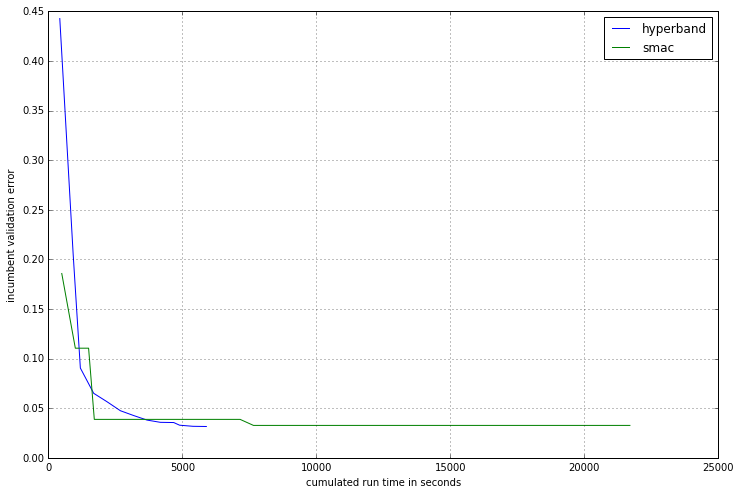

In [21]:
plt.figure(figsize=(12, 8))
# for i, incs in enumerate(rand_incumbents):
plt.plot(hb_wall_clock_time,hb_incumbent_performance, label = "hyperband")
plt.plot(wall_clock_time,incumbent_performance, label = "smac")
plt.grid(True)
# plt.yscale('log')
plt.xlabel("cumulated run time in seconds")
plt.ylabel("incumbent validation error")
plt.legend(loc='best')